# SMIRKS for Planar and Pyramidal Nitrogens

This notebook was used to check the SMIRKS I (Caitlin Bannan) wrote to separate nitrogens into planar or pyramidal nitrogens, based on work Victoria (Vickie) Lim did in the Mobley Lab with QM calculations previously.

In [2]:
from openeye import oechem
import oenotebook as oenb
import pandas as pd

** Methods **

In [3]:
def get_mol(smiles):
    """
    Returns an oemol for a given smiles
    """
    m = oechem.OEMol()
    oechem.OESmilesToMol(m,smiles)
    oechem.OEAddExplicitHydrogens(m)
    return m

In [4]:
def get_my_label(mol, typelist, replacements):
    """
    Returns the last label in a list that matches the molecule
    mol: oemol
    typelist: list of tuples with the format (smirks, label)
    """
    current_label = None
    for (smirks, label) in typelist:
        new_smirks = oechem.OESmartsLexReplace(smirks, replacements)
        ss = oechem.OESubSearch(new_smirks)
        if ss.SingleMatch(mol):
            current_label = label
    return current_label

### Reference categories

Here I am following [Vickie's documentation](https://mobleylab.slack.com/files/U1B55RSBH/F6KPMBXEU/plan2pyr.pdf)
where the planarity of tetrahedral nitrogens can be divided into 3 categories:

* Pyramidal (`pyr`): 'typical' nitrogen with an average angle of 109º
* Planar (`pla`): planar nitrogens with an average angle near 120º
* Partially planar (`part`): follow between the two categories above with angles around 115º

First, I create a dataframe with the example molecules and a column with the `'ref_type'` matching the QM calculations Vickie did last August. 

In [5]:
# dictionary of Vickie's types
vickie = {1:'pyr', 2:'pla', 3:'pla', 4:'part', 5:'pyr', 6:'part', 7:'pyr', 8:'pyr', 
          9:'part', 10:'part', 11:'pla', 12:'part'}

,labels,smiles,mols,ref_type
0,1,CNC,,pyr
1,2,CNC(=O)C,,pla
2,3,CNC(=O)OC,,pla
3,4,CNC(=O)NC,,part
4,5,CNS(=O)(=O)C,,pyr
5,6,CS(=O)(=O)Nc1ncncc1,,part
6,7,CS(=O)(=O)Nc1ccccc1,,pyr
7,8,CNc1ccc([O-])cc1,,pyr
8,9,CNc1ccc(N)cc1,,part
9,10,CNc1ccccc1,,part

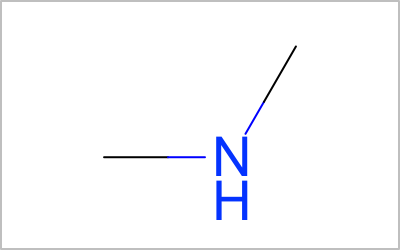
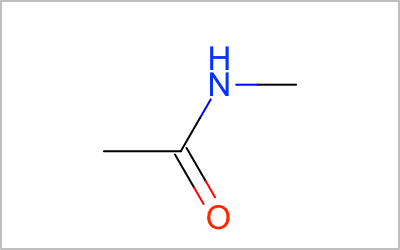
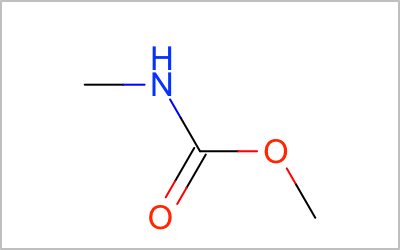
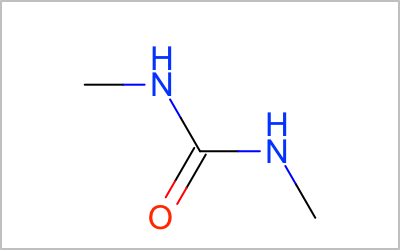
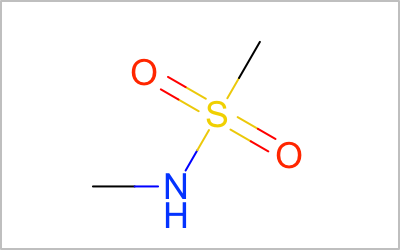
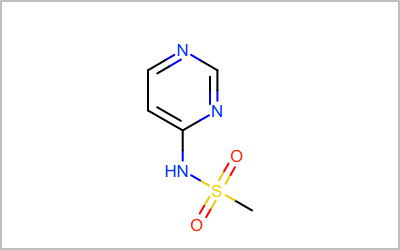
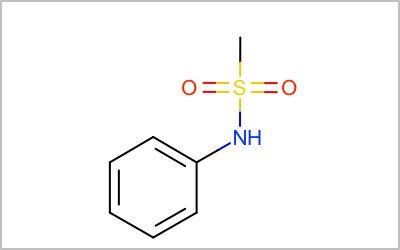
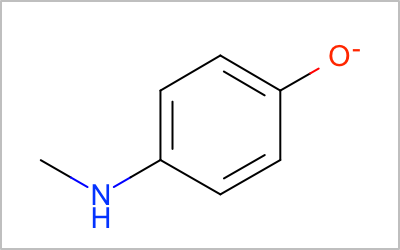
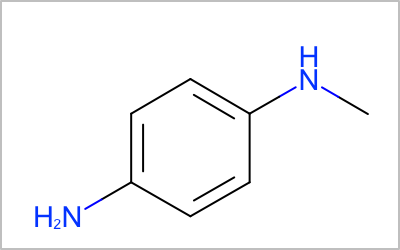
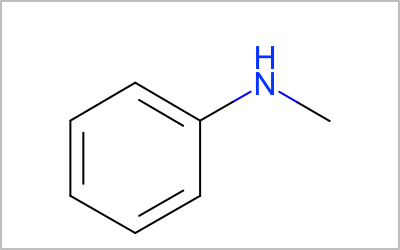
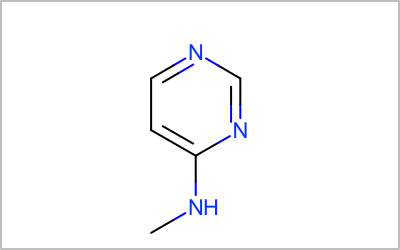
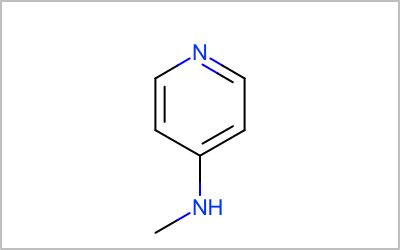

In [6]:
# dictionary of molecule # --> SMILES
smiles = {1:'CNC', 2:'CNC(=O)C', 3:'CNC(=O)OC', 4:'CNC(=O)NC', 
          5:'CNS(=O)(=O)C', 6:'CS(=O)(=O)Nc1ncncc1', 7:'CS(=O)(=O)Nc1ccccc1',
         8:'CNc1ccc([O-])cc1', 9:'CNc1ccc(N)cc1', 10:'CNc1ccccc1', 11:'CNc1ncncc1', 12:'CNc1ccncc1'}
labels = [l for l in smiles.keys()]
df = pd.DataFrame()

# Add data to dataframe
df['labels'] = labels
df['smiles'] = df['labels'].apply(smiles.get)
df['mols'] = df.smiles.apply(get_mol)
df['ref_type'] = df['labels'].apply(vickie.get)

# Visualize the dataframe with molecules and labels

oenb.render_dataframe(df, mol_col='mols')

### My SMIRKS patterns

This section uses my own SMIRKS patterns. They are each assigned the same three categories as above. As with the SMIRNOFF format, these are assigned a label based on a last one wins assignment. 

I created two new replacement patterns; right now these are written exclusively for the specific example molecules with these two categories:

* aromatic electron donating group (`aro_edg`): This seems to only work with "EXTRA" electron donating groups, `[O-1]` in this case
* aromatic electron withdrawing group (`aro_ewg`): Aromatic rings that are electron withdrawing, the pyrimidine in this case. 

If we were going to actually fit these parameters we would want to more carefully identify what things should fall into the two categories above. However, these SMIRKS patterns can still demonstrate how the SMIRNOFF format allows for more complex chemistry to easilly be added to a force field. 

In [7]:
# Replacement strings 
replace = [
    ('aro_edg', '[#6a$(*1ccc(-[#8-1X1])cc1)]'),
    ('aro_ewg', '[#6a$(*1ncncc1)]')
]

smirks_list = [
    ('[*:1]-[#7X3:2](-[*:3])-[*:4]', 'pyr'),
    ('[*:1]-[#7X3:2](-[#6X3:3]=O)-[*:4]', 'pla'),
    ('[*:1]-[#7X3:2](-[#6X3:3](=[#8])-[#7])-[*:4]', 'part'),
    ('[*:1]-[#7X3:2](-[#6a:3])-[*:4]', 'part'),
    ('[*:1]-[#7X3:2](-[$aro_edg:3])-[*:4]', 'pyr'),
    ('[*:1]-[#7X3:2](-[$aro_ewg:3])-[*:4]', 'pla'),
    ('[#16$(*(=O)=O):1]-[#7X3:2](-[#6a:3])-[*:4]', 'pyr'),
    ('[#16$(*(=O)=O):1]-[#7X3:2](-[$aro_ewg:3])-[*:4]', 'part'),
]

# Assign
df['assigned_type'] = df['mols'].apply(lambda x: get_my_label(x, smirks_list, replace))

**Check that all assigned types match Vickie's categories**

If there are any disagreements then those lines from the dataframe above will be shown below

In [8]:
mismatch = df[df[['ref_type', 'assigned_type']].apply(lambda x: x[0] != x[1], axis=1)]
oenb.render_dataframe(mismatch, mol_col='mols')

,labels,smiles,mols,ref_type,assigned_type
